In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy_financial as npf
import datetime as dt
import cpi
from calendar import isleap
from utils.time import convert_to_decimal_year, convert_to_datetime
from utils.data import zero_pad
from typing import List, Union
from utils.time import convert_multiple_formats_to_datetime
import geopandas as gpd
import json
from random import randint
import warnings


warnings.filterwarnings("ignore")
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [145]:
brent_df = pd.read_csv("/Volumes/Samsung_T5/data/oilgas/BrentOilPrices.csv")
# data from https://www.usinflationcalculator.com
usd_df = pd.read_csv("/Volumes/Samsung_T5/data/conversion_factors_to_2023_dollars.csv")

brent_df["date"] = [
    convert_multiple_formats_to_datetime(x, formats=["%d-%b-%y", "%b %d, %Y"])
    for x in brent_df["Date"]
]
brent_df["year"] = [int(d.year) for d in brent_df["date"]]
brent_df = brent_df.merge(usd_df, on="year")
brent_df["usd_2023"] = brent_df["Price"] * brent_df["conversion_factor_to_2023_dollars"]
brent_df["usd_cpi_2023"] = [
    cpi.inflate(d, y, to=2023) for d, y in zip(brent_df["Price"], brent_df["year"])
]
brent_df["rolling_annual_average_usd_per_bbl"] = (
    brent_df.usd_cpi_2023.rolling(365).mean().shift(-182)
)

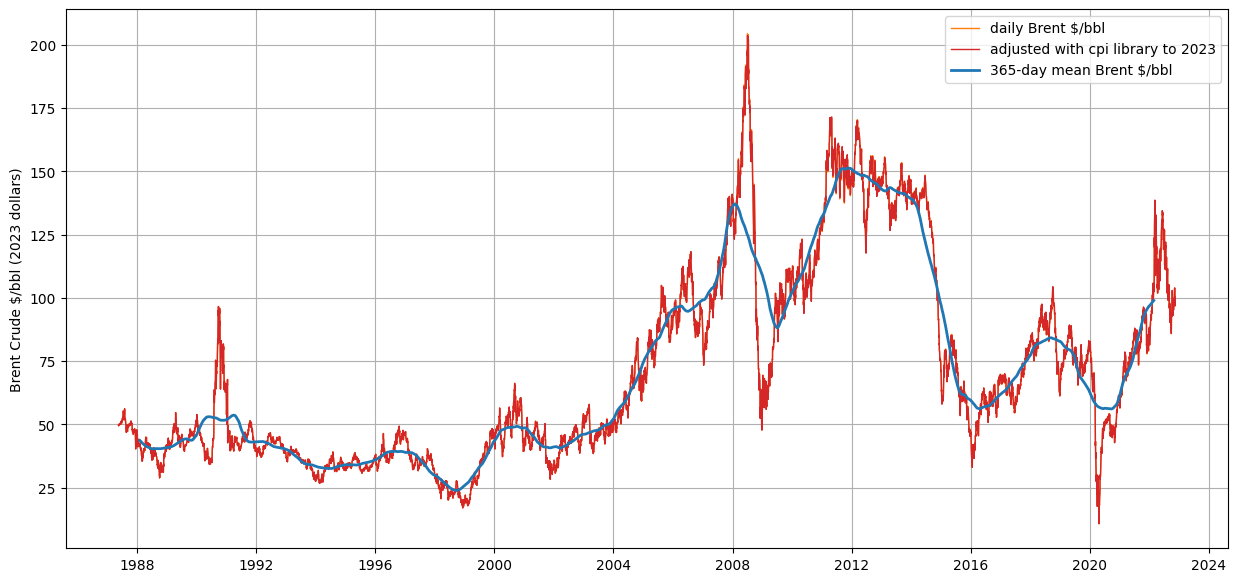

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
plt.subplot(1, 1, 1)
plt.plot(
    brent_df.date,
    brent_df.usd_2023,
    color="tab:orange",
    lw=1,
    label="daily Brent $/bbl",
)
plt.plot(
    brent_df.date,
    brent_df.usd_cpi_2023,
    color="tab:red",
    lw=1,
    label="adjusted with cpi library to 2023",
)
plt.plot(
    brent_df.date,
    brent_df.usd_cpi_2023.rolling(365).mean().shift(-182),
    color="tab:blue",
    lw=2,
    label="365-day mean Brent $/bbl",
)
plt.grid()
plt.ylabel("Brent Crude $/bbl (2023 dollars)")
plt.legend()

In [ ]:
# 10 year cleveland fed inflation projection is 2.45%
# https://www.clevelandfed.org/indicators-and-data/inflation-expectations#

In [226]:
from projects.ccs.src.ccs_project import CCSProject

In [227]:
industries = [
    "ngp",
    "ethanol",
    "ammonia",
    "hydrogen",
    "cement",
    "cracker",
    "steel",
    "industrial",
    "coal_power_85pct",
    "ng_power_85pct",
]

capture_df = pd.read_excel(
    "/Users/lindseygulden/dev/leg-up/projects/ccs/gaffney_cline_assumptions_and_modified_assumptions.xlsx",
    "modified_assumptions",
    index_col=[0],
)

capture = []
for industry in industries:
    row_dict = {}
    row_dict["industry"] = industry
    row_dict["low"] = capture_df.loc[
        "Average total capture cost (US$/tonne)", industry + "_low"
    ]
    row_dict["high"] = capture_df.loc[
        "Average total capture cost (US$/tonne)", industry + "_high"
    ]
    row_dict["center"] = (row_dict["low"] + row_dict["high"]) / 2
    row_dict["center_shifted_high"] = 0.75 * (row_dict["low"] + row_dict["high"])
    row_dict["center_shifted-low"] = 0.25 * (row_dict["low"] + row_dict["high"])
    capture.append(row_dict)

In [238]:
capture_df = pd.DataFrame(capture)
capture_df.set_index("industry", inplace=True)

In [ ]:
row_dict = {}

In [262]:
# RHG cases
# brent oil prices (2022 dollars)
rhg_low = [102, 92, 91, 81, 79.5, 78, 77.5, 76, 77, 78, 79, 80, 81, 81]
rhg_mid = [102, 91, 92, 86.5, 87, 88, 88.5, 89, 90, 90.5, 91, 91, 92, 92]
rhg_high = [102, 92, 97.5, 92.5, 94, 95, 96, 97.5, 99, 100, 95, 96, 97.5, 96]

# convert to 2023 dollars (* 1.04); put in dictionary
rhg_brent_2023_usd = {}
dummy_first_year = 80
rhg_brent_2023_usd["low"] = [dummy_first_year] + [1.04 * x for x in rhg_low]
rhg_brent_2023_usd["mid"] = [dummy_first_year] + [1.04 * x for x in rhg_mid]
rhg_brent_2023_usd["high"] = [dummy_first_year] + [1.04 * x for x in rhg_high]

rhg_oil_cases_df = pd.DataFrame(rhg_brent_2023_usd)

* Our low emissions pathway represents a reasonable low bound on US emissions through 2035, combining our most aggressive cost declines and performance improvements for a range of clean energy technologies ... with our highest projected prices for fossil fuels in the future and economic growth consistent with current Congressional Budget Office (CBO) projections through the early 2030s.
* Our high emissions pathway represents a
reasonable high bound on emissions through
2035 and is effectively the opposite scenario of
low emissions: more expensive clean
technologies, cheapest fossil fuel prices, and
faster-than-expected economic growth.
* Finally, our mid emissions pathway takes more
moderate projections for many of these factors,
with continued cost declines for clean
technologies, but not as aggressive as in the low
emissions scenario; fossil fuel prices roughly
consistent with recent historical averages; and
continued use of CBO’s baseline economic
growth.

- rhg_low_emissions_scenario #low prices for 'cleantech energy'; high-rhg-case fossil fuel prices; cbo expected economic groupth (1.8)
- rhg_high_emissions_scenario # high prices for clean-tech; cheapest fossil fuel; fast economic grouth (2.2)
- rhg_mid_emissions_scneario #midlle all. (1.8)

In [263]:
rhg_oil_cases_df.to_csv("rhg_oil_price_cases_brent_crude_2023_usd.csv")

In [264]:
rhg_oil_cases_df

,low,mid,high
0,80.00,80.00,80.00
1,106.08,106.08,106.08
2,95.68,94.64,95.68
3,94.64,95.68,101.40
4,84.24,89.96,96.20
5,82.68,90.48,97.76
6,81.12,91.52,98.80
7,80.60,92.04,99.84
8,79.04,92.56,101.40
9,80.08,93.60,102.96


In [269]:
# Project parameters for RHG cases:
datalist = []
for industry in industries:
    rhg_low_emissions_pathway_params = {
        "project_length_yrs": 15,
        "inflation_rate": 0.018,
        "discount_rate": 0.12,
        "industry": industry,
        "tco2_sequestered_per_yr": [0] * 3 + [1] * 12,
        "oil_prices": list(rhg_oil_cases_df["high"]),
        "oil_breakeven_price": 25,
        "capture_cost_usd_per_tco2": capture_df.loc[industry, "low"],
        "transport_cost_usd_per_tco2": transport_low,
        "storage_cost_usd_per_tco2": 9,
        "rhg_emissions_pathway": "low",
    }

    rhg_mid_emissions_pathway_params = {
        "project_length_yrs": 15,
        "inflation_rate": 0.018,
        "discount_rate": 0.12,
        "industry": industry,
        "tco2_sequestered_per_yr": [0] * 3 + [1] * 12,
        "oil_prices": list(rhg_oil_cases_df["mid"]),
        "oil_breakeven_price": 25,
        "capture_cost_usd_per_tco2": capture_df.loc[industry, "center"],
        "transport_cost_usd_per_tco2": transport_low,
        "storage_cost_usd_per_tco2": 9,
        "rhg_emissions_pathway": "mid",
    }

    rhg_high_emissions_pathway_params = {
        "project_length_yrs": 15,
        "inflation_rate": 0.022,
        "discount_rate": 0.12,
        "industry": industry,
        "tco2_sequestered_per_yr": [0] * 3 + [1] * 12,
        "oil_prices": list(rhg_oil_cases_df["low"]),
        "oil_breakeven_price": 25,
        "capture_cost_usd_per_tco2": capture_df.loc[industry, "high"],
        "transport_cost_usd_per_tco2": transport_low,
        "storage_cost_usd_per_tco2": 9,
        "rhg_emissions_pathway": "high",
    }

    for params in [
        rhg_low_emissions_pathway_params,
        rhg_mid_emissions_pathway_params,
        rhg_high_emissions_pathway_params,
    ]:
        project = CCSProject(params)
        params["total_eor_usd_per_tco2"] = project.total_eor_usd_per_tco2
        params["total_gs_usd_per_tco2"] = project.total_gs_usd_per_tco2
        datalist.append(params)

INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.
INFO:root: Initialized an ethanol CCS simulation.


In [270]:
rhg_df = pd.DataFrame(datalist)
rhg_df.info()

rhg_df[
    [
        "industry",
        "rhg_emissions_pathway",
        "total_eor_usd_per_tco2",
        "total_gs_usd_per_tco2",
    ]
].pivot(index="industry", columns="rhg_emissions_pathway").to_clipboard()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   project_length_yrs           30 non-null     int64  
 1   inflation_rate               30 non-null     float64
 2   discount_rate                30 non-null     float64
 3   industry                     30 non-null     object 
 4   tco2_sequestered_per_yr      30 non-null     object 
 5   oil_prices                   30 non-null     object 
 6   oil_breakeven_price          30 non-null     int64  
 7   capture_cost_usd_per_tco2    30 non-null     float64
 8   transport_cost_usd_per_tco2  30 non-null     float64
 9   storage_cost_usd_per_tco2    30 non-null     int64  
 10  rhg_emissions_pathway        30 non-null     object 
 11  total_eor_usd_per_tco2       30 non-null     float64
 12  total_gs_usd_per_tco2        30 non-null     float64
dtypes: float64(6), int64(3

In [236]:
capture_df

,industry,low,high,center,center_shifted_high,center_shifted-low
0,ngp,24.64,36.72,30.680,46.0200,15.3400
1,ethanol,24.92,36.39,30.655,45.9825,15.3275
2,ammonia,21.81,32.08,26.945,40.4175,13.4725
3,hydrogen,65.44,93.91,79.675,119.5125,39.8375
4,cement,69.88,101.94,85.910,128.8650,42.9550
5,cracker,104.12,160.30,132.210,198.3150,66.1050
6,steel,81.04,120.42,100.730,151.0950,50.3650
7,industrial,117.81,181.90,149.855,224.7825,74.9275
8,coal_power_85pct,88.35,132.27,110.310,165.4650,55.1550
9,ng_power_85pct,99.30,150.21,124.755,187.1325,62.3775


In [223]:
# transport costs in units of usd/tco2, adjusted from 2021 to 2023 dollars, from NPC CCS report
transport_low = 2.2
transport_med = 22.4
transport_high = 42.6

unit_rate = {"eor": {}, "gs": {}}

n_trials = 1000
for industry in industries:
    low = capture_df.loc["Average total capture cost (US$/tonne)", industry + "_low"]
    high = capture_df.loc["Average total capture cost (US$/tonne)", industry + "_high"]
    med = (low + high) / 2
    total_eor_usd_per_tco2 = []
    total_gs_usd_per_tco2 = []
    # series of trials
    for _ in range(n_trials):
        capture_cost = np.random.triangular(low, med, high)
        storage_cost = 9
        transport_cost = np.random.triangular(low, med, high)

        future_oil_prices = list(
            brent_df.rolling_annual_average_usd_per_bbl.sample(
                n=15,
                replace=True,
            )
        )

        eor_revenue = eor_total_unit_revenue(
            [60] * 15, [0, 0, 0] + [1] * 12, 3, 25, oil_prices, 0.025, 0.12
        )
        geologic_storage_revenue = geologic_storage_total_unit_revenue(
            [85] * 15, [0, 0, 0] + [1] * 12, 0.025, 0.12
        )
        total_eor_usd_per_tco2.append(
            eor_revenue - capture_cost - storage_cost - transport_cost
        )
        total_gs_usd_per_tco2.append(
            geologic_storage_revenue - capture_cost - storage_cost - transport_cost
        )
    unit_rate["eor"][industry] = total_eor_usd_per_tco2
    unit_rate["gs"][industry] = total_gs_usd_per_tco2

(array([ 2.,  2.,  0.,  3.,  2.,  3.,  4.,  5.,  8., 12., 12., 16., 20.,
        18., 27., 23., 32., 28., 40., 42., 43., 58., 44., 39., 51., 45.,
        47., 51., 41., 38., 34., 28., 37., 35., 12., 14., 24., 13., 12.,
         6.,  4.,  6.,  5.,  4.,  5.,  2.,  0.,  2.,  0.,  1.]),
 array([-7.76038924, -7.36133304, -6.96227684, -6.56322064, -6.16416444,
        -5.76510824, -5.36605204, -4.96699584, -4.56793964, -4.16888344,
        -3.76982724, -3.37077104, -2.97171484, -2.57265864, -2.17360244,
        -1.77454624, -1.37549004, -0.97643384, -0.57737764, -0.17832144,
         0.22073476,  0.61979096,  1.01884716,  1.41790336,  1.81695956,
         2.21601576,  2.61507196,  3.01412816,  3.41318436,  3.81224056,
         4.21129676,  4.61035296,  5.00940916,  5.40846536,  5.80752157,
         6.20657777,  6.60563397,  7.00469017,  7.40374637,  7.80280257,
         8.20185877,  8.60091497,  8.99997117,  9.39902737,  9.79808357,
        10.19713977, 10.59619597, 10.99525217, 11.39430837,

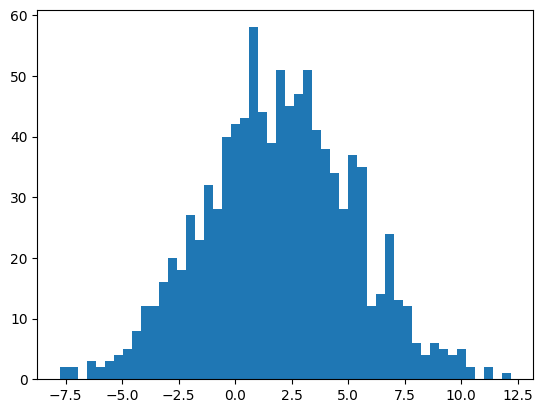

In [224]:
plt.hist(unit_rate["eor"]["ethanol"], bins=50)

In [127]:
expand_dict = {
    "PP": "co2_supplier",
    "MM": "petroleum products",
    "AA": "pulp and paper",
    "DD": "electric transmission",
    "FF": "underground coal mines",
    "NN": "natural gas and ngls",
    "TT": "industrial waste landfills",
    "C": "general combustion",
    "D": "power plant",
    "G": "ammonia",
    "H": "cement",
    "J": "ethanol",
    "Q": "iron_steel",
    "V": "nitric acid",
    "P": "hydrogen",
    "Y": "refineries",
    "X": "petrochemicals",
    "W": "natural gas processing",
    "S": "lime manufacturing",
    "F": "aluminum",
}

In [128]:
df = pd.read_csv("/Users/lindseygulden/Downloads/epa_flight_2022_co2.csv")
# subparts: https://www.epa.gov/ghgreporting/resources-subpart-ghg-reporting

In [129]:
df["subparts_explained"] = df["SUBPARTS"].copy(deep=True).replace(",", " ")
for k, v in expand_dict.items():
    df["subparts_explained"] = [x.replace(k, v) for x in df["subparts_explained"]]

In [130]:
df.subparts_explained.unique()

array(['power plant', 'general combustion,ammonia,co2_supplier',
       'general combustion', 'general combustion,power plant',
       'general combustion,power plant,co2_supplier', 'hydrogen',
       'general combustion,power plant,aluminum',
       'general combustion,petroleum products,refineries', 'cement',
       'general combustion,cement', 'general combustion,petrochemicals',
       'general combustion,hydrogen,co2_supplier',
       'hydrogen,co2_supplier',
       'general combustion,natural gas processing',
       'general combustion,petroleum products,industrial waste landfills,refineries',
       'general combustion,petroleum products,hydrogen,industrial waste landfills,refineries',
       'general combustion,petroleum products,hydrogen,co2_supplier,refineries',
       'general combustion,power plant,electric transmission,petroleum products,hydrogen,refineries',
       'general combustion,natural gas and ngls,natural gas processing',
       'general combustion,iron_steel',
  

(23.0, 50.0)

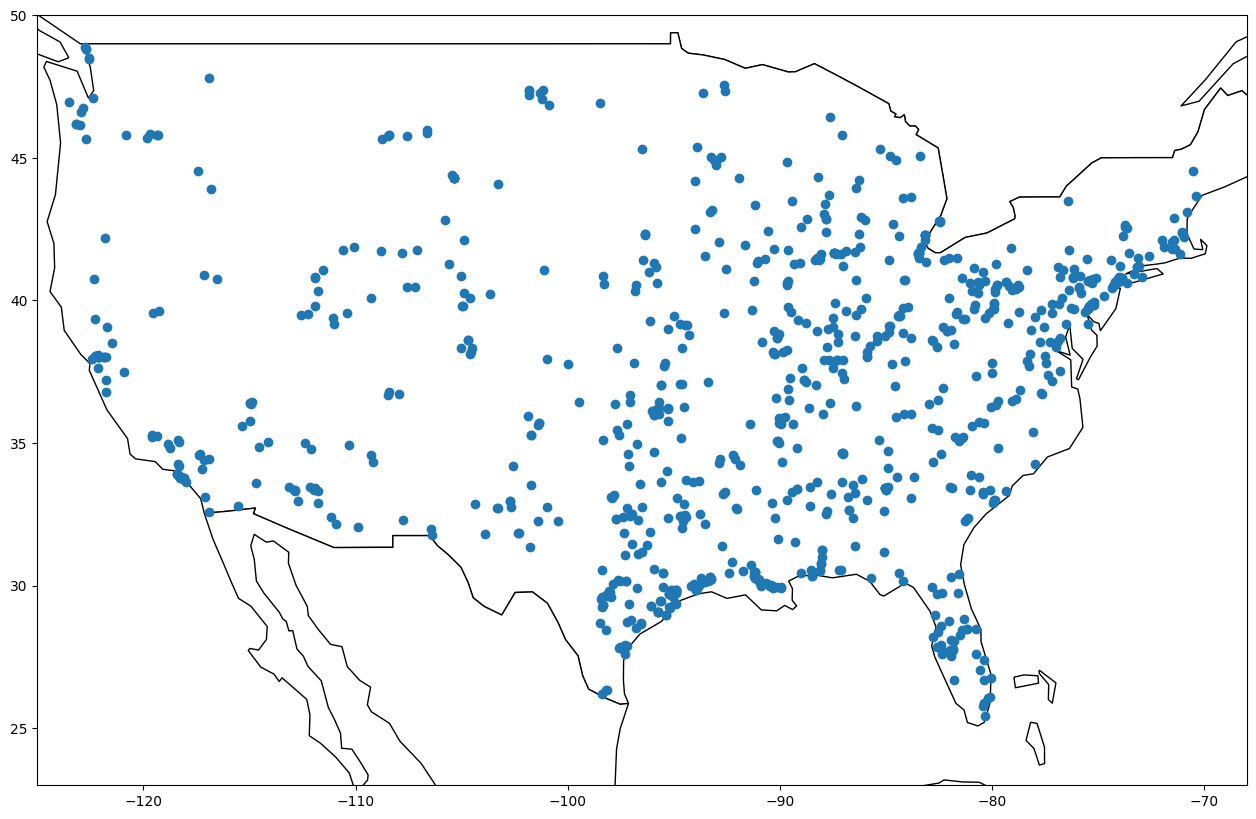

In [141]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
world.plot(ax=ax, color="white", edgecolor="black")
gdf.plot(ax=ax)
ax.set_xlim([-125, -68])
ax.set_ylim([23, 50])

In [132]:
df.columns = [x.lower() for x in df.columns.values]